# Install and import library

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from datetime import datetime

In [ ]:
from sklearn.preprocessing import MinMaxScaler, normalize
from sklearn.metrics import mean_squared_error
import math
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_error

# Evaluation function:

In [ ]:
def evaluation(y_test, y_pred):
  print(f'RMSE = {math.sqrt(mean_squared_error(y_test, y_pred))}')
  print(f'MAE = {mean_absolute_error(y_test, y_pred)}')
  print(f'MAPE = {mean_absolute_percentage_error(y_test, y_pred)*100}')

# Preprocessing Dataset

In [ ]:
df = pd.read_csv('/content/ELC.csv')

In [ ]:
df

,Date,Price
0,12/15/2016,20446.0
1,12/16/2016,20298.3
2,12/19/2016,20298.3
3,12/20/2016,20076.9
4,12/21/2016,19855.5
...,...,...
1744,12/11/2023,19350.0
1745,12/12/2023,19350.0
1746,12/13/2023,18900.0
1747,12/14/2023,19150.0


In [ ]:
list_reference_date = [datetime.strptime(date_str, '%m/%d/%Y') for date_str in df['Date']]

In [ ]:
reference_date = min(list_reference_date)
from datetime import datetime
df['numerical_date'] = df['Date'].apply(lambda x: (datetime.strptime(x, '%m/%d/%Y') - reference_date).days)

In [ ]:
df_ = df['Price'].values.reshape(-1, 1)

In [ ]:
scaler = MinMaxScaler()
df['Price'] = scaler.fit_transform(df_)
df1= df['Price'].copy()

In [ ]:
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step)]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step])
	return np.array(dataX), np.array(dataY)

# Split train, test

In [ ]:
def split_data(train_ratio, test_ratio):
  train_size = int(train_ratio * len(df1))
  test_size = int(test_ratio * len(df1))

  train_data = df1[:train_size]
  test_data = df1[train_size:train_size+test_size].reset_index(drop=True)
  return train_size, test_size, train_data, test_data

# **BNN**

## Split data 7:3


In [ ]:
train_size, test_size, train_data, test_data = split_data(0.7, 0.3)

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.distributions import Normal

# Set random seed for reproducibility
torch.manual_seed(42)

# Define the hyperparameters
input_dim = X_train.shape[1]  # Dimension of input features
output_dim = 1  # Dimension of output (predicted value)
hidden_units = 64  # Number of hidden units
learning_rate = 0.001
num_epochs = 500
prior_sigma = 0.1  # Standard deviation of the prior

# Apply Min-Max scaling to the time series data

# Convert the scaled data to tensors
targets = torch.tensor(y_train).view(-1, 1).to(torch.float32)
time_series = torch.tensor(X_train).to(torch.float32)

# Create a DataLoader for batching and shuffling the data
dataset = TensorDataset(time_series, targets)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Define the BNN model
class BNNModel(nn.Module):
    def __init__(self, input_dim, hidden_units, output_dim, prior_sigma):
        super(BNNModel, self).__init__()
        self.layer1 = nn.Linear(input_dim, hidden_units)
        self.relu = nn.ReLU()
        self.layer2 = nn.Linear(hidden_units, output_dim)
        self.prior_sigma = prior_sigma

    def forward(self, x):
        x = self.layer1(x)
        x = self.relu(x)
        x = self.layer2(x)
        return x

    def kl_divergence(self):
        kl = 0
        for layer in [self.layer1, self.layer2]:
            weights = layer.weight
            kl += 0.5 * (torch.log(self.prior_sigma**2 / weights.var()) + (weights.var() + (weights.mean() - 0)**2) / self.prior_sigma**2 - 1)
        return kl

# Initialize the BNN model
model = BNNModel(input_dim, hidden_units, output_dim, prior_sigma)

# Define the loss function with KL divergence and negative log likelihood
def bnn_loss(outputs, targets):
    kl_divergence = model.kl_divergence()
    log_likelihood = -Normal(outputs, 1).log_prob(targets).mean()  # Assuming outputs is a Normal distribution
    return kl_divergence + log_likelihood

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
lowest_loss = float('inf')  # Initialize with positive infinity

# Training loop
for epoch in range(num_epochs):
    for batch_inputs, batch_targets in dataloader:
        # Forward pass
        predictions = model(batch_inputs)

        # Compute the combined loss (KL + negative log likelihood)
        loss = bnn_loss(predictions, batch_targets)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Update lowest_loss if current loss is lower
        if loss < lowest_loss:
            lowest_loss = loss
            torch.save(model.state_dict(), '/content/best-model-parameters.pt')

    # Print the combined loss (KL + negative log likelihood) after each epoch
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}")


Epoch 1/500, Loss: 0.9582616090774536
Epoch 2/500, Loss: 0.9204931855201721
Epoch 3/500, Loss: 0.9195945858955383
Epoch 4/500, Loss: 0.9189871549606323
Epoch 5/500, Loss: 0.9196301698684692
Epoch 6/500, Loss: 0.9189478754997253
Epoch 7/500, Loss: 0.9189541935920715
Epoch 8/500, Loss: 0.9202816486358643
Epoch 9/500, Loss: 0.9200780391693115
Epoch 10/500, Loss: 0.9193892478942871
Epoch 11/500, Loss: 0.918994128704071
Epoch 12/500, Loss: 0.9192362427711487
Epoch 13/500, Loss: 0.919215977191925
Epoch 14/500, Loss: 0.9189714193344116
Epoch 15/500, Loss: 0.9189453721046448
Epoch 16/500, Loss: 0.9189963340759277
Epoch 17/500, Loss: 0.9190347194671631
Epoch 18/500, Loss: 0.9191891551017761
Epoch 19/500, Loss: 0.9193159341812134
Epoch 20/500, Loss: 0.9189867973327637
Epoch 21/500, Loss: 0.9190471768379211
Epoch 22/500, Loss: 0.9189735651016235
Epoch 23/500, Loss: 0.9191079139709473
Epoch 24/500, Loss: 0.9190236926078796
Epoch 25/500, Loss: 0.9190499782562256
Epoch 26/500, Loss: 0.91951143741607

In [ ]:
print(model)

BNNModel(
  (layer1): Linear(in_features=100, out_features=64, bias=True)
  (relu): ReLU()
  (layer2): Linear(in_features=64, out_features=1, bias=True)
)


In [ ]:
# Initialize the BNN model
best_model = BNNModel(input_dim, hidden_units, output_dim, prior_sigma)

# Load the state dictionary
state_dict = torch.load('/content/best-model-parameters.pt')

# Load the state dictionary into the model
best_model.load_state_dict(state_dict)

# Test the model
test = torch.tensor(X_test).to(torch.float32)
y_pred_bnn_test = best_model(test)


In [ ]:
# Forecast the next 30 days
forecasted_next_30_days = []

# Assuming df1 is your dataframe
last_10_days = df1.iloc[-time_step:].values.astype(np.float32)  # Apply normalization if needed

for i in range(30):
    X_forecast_tensor = torch.tensor(last_10_days[-time_step:]).unsqueeze(0).to(torch.float32)
    y_pred = best_model(X_forecast_tensor)
    forecasted_next_30_days.append(y_pred.item())

    # Update last_10_days with the latest prediction
    last_10_days = np.append(last_10_days, y_pred.detach().numpy())
    last_10_days = last_10_days[-time_step:]

# Print or use forecasted_next_30_days as needed
print(forecasted_next_30_days)


[0.6785373687744141, 0.6900057792663574, 0.7133229374885559, 0.7371909022331238, 0.7614540457725525, 0.7699434161186218, 0.7700715065002441, 0.7919707298278809, 0.798660933971405, 0.8190241456031799, 0.8217542767524719, 0.8357576131820679, 0.8594772815704346, 0.8856526017189026, 0.9032979607582092, 0.9064034223556519, 0.9174367785453796, 0.9279447793960571, 0.942529022693634, 0.9610180258750916, 0.9773841500282288, 0.9891018271446228, 0.9970994591712952, 1.0113062858581543, 1.0136377811431885, 1.0218290090560913, 1.0463234186172485, 1.0716509819030762, 1.1028090715408325, 1.1234421730041504]


In [ ]:
forecasted_next_30_days

[0.6785373687744141,
 0.6900057792663574,
 0.7133229374885559,
 0.7371909022331238,
 0.7614540457725525,
 0.7699434161186218,
 0.7700715065002441,
 0.7919707298278809,
 0.798660933971405,
 0.8190241456031799,
 0.8217542767524719,
 0.8357576131820679,
 0.8594772815704346,
 0.8856526017189026,
 0.9032979607582092,
 0.9064034223556519,
 0.9174367785453796,
 0.9279447793960571,
 0.942529022693634,
 0.9610180258750916,
 0.9773841500282288,
 0.9891018271446228,
 0.9970994591712952,
 1.0113062858581543,
 1.0136377811431885,
 1.0218290090560913,
 1.0463234186172485,
 1.0716509819030762,
 1.1028090715408325,
 1.1234421730041504]

In [ ]:
evaluation(scaler.inverse_transform(y_pred_bnn_test.detach().numpy()), scaler.inverse_transform(y_test.reshape(-1,1)))

RMSE = 890.5017031257979
MAE = 626.1007032173462
MAPE = 3.929847834984425


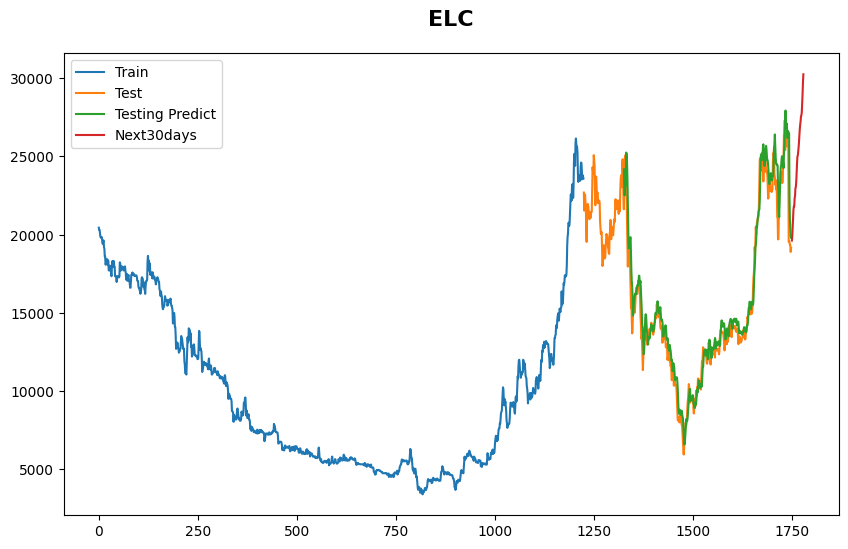

In [ ]:
import numpy as np

forecasted_next_30_days_reshaped = np.array(forecasted_next_30_days).reshape(-1, 1)


plt.figure(figsize=(10, 6))

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(train_data_index, scaler.inverse_transform(np.array(train_data).reshape(-1, 1)))

test_data_index = pd.RangeIndex(start=train_size, stop=train_size + test_size, step=1)
plt.plot(test_data_index, scaler.inverse_transform(np.array(test_data).reshape(-1, 1)))

test_data_index = pd.RangeIndex(start=train_size + 101, stop=train_size + test_size, step=1)
plt.plot(test_data_index, scaler.inverse_transform(y_pred_bnn_test.detach().numpy()))
# Lấy index từ ngày tiếp theo trở đi
index_forecasted = range(len(df1), len(df1)+ len(forecasted_next_30_days))
plt.plot(index_forecasted, scaler.inverse_transform(forecasted_next_30_days_reshaped))
plt.title('ELC', fontweight='bold', fontsize=16, pad=20)
plt.legend(['Train', 'Test', 'Testing Predict', 'Next30days'])
plt.show()


## Split data 8:2


In [ ]:
train_size, test_size, train_data, test_data = split_data(0.8, 0.2)

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.distributions import Normal

# Set random seed for reproducibility
torch.manual_seed(42)

# Define the hyperparameters
input_dim = X_train.shape[1]  # Dimension of input features
output_dim = 1  # Dimension of output (predicted value)
hidden_units = 64  # Number of hidden units
learning_rate = 0.001
num_epochs = 500
prior_sigma = 0.1  # Standard deviation of the prior

# Apply Min-Max scaling to the time series data

# Convert the scaled data to tensors
targets = torch.tensor(y_train).view(-1, 1).to(torch.float32)
time_series = torch.tensor(X_train).to(torch.float32)

# Create a DataLoader for batching and shuffling the data
dataset = TensorDataset(time_series, targets)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Define the BNN model
class BNNModel(nn.Module):
    def __init__(self, input_dim, hidden_units, output_dim, prior_sigma):
        super(BNNModel, self).__init__()
        self.layer1 = nn.Linear(input_dim, hidden_units)
        self.relu = nn.ReLU()
        self.layer2 = nn.Linear(hidden_units, output_dim)
        self.prior_sigma = prior_sigma

    def forward(self, x):
        x = self.layer1(x)
        x = self.relu(x)
        x = self.layer2(x)
        return x

    def kl_divergence(self):
        kl = 0
        for layer in [self.layer1, self.layer2]:
            weights = layer.weight
            kl += 0.5 * (torch.log(self.prior_sigma**2 / weights.var()) + (weights.var() + (weights.mean() - 0)**2) / self.prior_sigma**2 - 1)
        return kl

# Initialize the BNN model
model = BNNModel(input_dim, hidden_units, output_dim, prior_sigma)

# Define the loss function with KL divergence and negative log likelihood
def bnn_loss(outputs, targets):
    kl_divergence = model.kl_divergence()
    log_likelihood = -Normal(outputs, 1).log_prob(targets).mean()  # Assuming outputs is a Normal distribution
    return kl_divergence + log_likelihood

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
lowest_loss = float('inf')  # Initialize with positive infinity

# Training loop
for epoch in range(num_epochs):
    for batch_inputs, batch_targets in dataloader:
        # Forward pass
        predictions = model(batch_inputs)

        # Compute the combined loss (KL + negative log likelihood)
        loss = bnn_loss(predictions, batch_targets)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Update lowest_loss if current loss is lower
        if loss < lowest_loss:
            lowest_loss = loss
            torch.save(model.state_dict(), '/content/best-model-parameters.pt')

    # Print the combined loss (KL + negative log likelihood) after each epoch
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}")


Epoch 1/500, Loss: 0.9535073637962341
Epoch 2/500, Loss: 0.9205380082130432
Epoch 3/500, Loss: 0.919526219367981
Epoch 4/500, Loss: 0.9193868637084961
Epoch 5/500, Loss: 0.919409453868866
Epoch 6/500, Loss: 0.9196699261665344
Epoch 7/500, Loss: 0.9191651940345764
Epoch 8/500, Loss: 0.9194371104240417
Epoch 9/500, Loss: 0.919219434261322
Epoch 10/500, Loss: 0.9190641641616821
Epoch 11/500, Loss: 0.9191412329673767
Epoch 12/500, Loss: 0.919432520866394
Epoch 13/500, Loss: 0.9193048477172852
Epoch 14/500, Loss: 0.9190317988395691
Epoch 15/500, Loss: 0.9191514849662781
Epoch 16/500, Loss: 0.9194682836532593
Epoch 17/500, Loss: 0.919018566608429
Epoch 18/500, Loss: 0.9191378355026245
Epoch 19/500, Loss: 0.9190898537635803
Epoch 20/500, Loss: 0.9191290736198425
Epoch 21/500, Loss: 0.9190717935562134
Epoch 22/500, Loss: 0.9195882678031921
Epoch 23/500, Loss: 0.9192328453063965
Epoch 24/500, Loss: 0.9193225502967834
Epoch 25/500, Loss: 0.9192267060279846
Epoch 26/500, Loss: 0.9190932512283325


In [ ]:
print(model)

BNNModel(
  (layer1): Linear(in_features=100, out_features=64, bias=True)
  (relu): ReLU()
  (layer2): Linear(in_features=64, out_features=1, bias=True)
)


In [ ]:
# Initialize the BNN model
best_model = BNNModel(input_dim, hidden_units, output_dim, prior_sigma)

# Load the state dictionary
state_dict = torch.load('/content/best-model-parameters.pt')

# Load the state dictionary into the model
best_model.load_state_dict(state_dict)

# Test the model
test = torch.tensor(X_test).to(torch.float32)
y_pred_bnn_test = best_model(test)


In [ ]:
# Forecast the next 30 days
forecasted_next_30_days = []

# Assuming df1 is your dataframe
last_10_days = df1.iloc[-time_step:].values.astype(np.float32)  # Apply normalization if needed

for i in range(30):
    X_forecast_tensor = torch.tensor(last_10_days[-time_step:]).unsqueeze(0).to(torch.float32)
    y_pred = best_model(X_forecast_tensor)
    forecasted_next_30_days.append(y_pred.item())

    # Update last_10_days with the latest prediction
    last_10_days = np.append(last_10_days, y_pred.detach().numpy())
    last_10_days = last_10_days[-time_step:]

# Print or use forecasted_next_30_days as needed
print(forecasted_next_30_days)


[0.6109676957130432, 0.5791022777557373, 0.5205658674240112, 0.47102880477905273, 0.4158926010131836, 0.3732609748840332, 0.3473404049873352, 0.3547571301460266, 0.3642003536224365, 0.35902154445648193, 0.34136176109313965, 0.32499533891677856, 0.34895652532577515, 0.3709490895271301, 0.40032321214675903, 0.4139244556427002, 0.4348113536834717, 0.4511357545852661, 0.4483570158481598, 0.4379984736442566, 0.4179188013076782, 0.404710978269577, 0.3886863589286804, 0.38354718685150146, 0.38767245411872864, 0.39825165271759033, 0.40937522053718567, 0.41661572456359863, 0.41948240995407104, 0.41024041175842285]


In [ ]:
scaler.inverse_transform(forecasted_next_30_days_reshaped)

array([[19619.93627739],
       [19893.92807245],
       [20450.99829954],
       [21021.22784525],
       [21600.89860755],
       [21803.71815449],
       [21806.7783618 ],
       [22329.97270632],
       [22489.80837351],
       [22976.30586261],
       [23041.53142589],
       [23376.08513653],
       [23942.771734  ],
       [24568.12630767],
       [24989.69158047],
       [25063.8841635 ],
       [25327.48207623],
       [25578.52872455],
       [25926.96088117],
       [26368.68165618],
       [26759.68472832],
       [27039.63175231],
       [27230.70317906],
       [27570.11847544],
       [27625.82022929],
       [27821.51685536],
       [28406.71279418],
       [29011.81360865],
       [29756.21152818],
       [30249.15695524]])

In [ ]:
evaluation(scaler.inverse_transform(y_pred_bnn_test.detach().numpy()), scaler.inverse_transform(y_test.reshape(-1,1)))

RMSE = 776.1490692273971
MAE = 534.5065563571069
MAPE = 3.2438070811225925


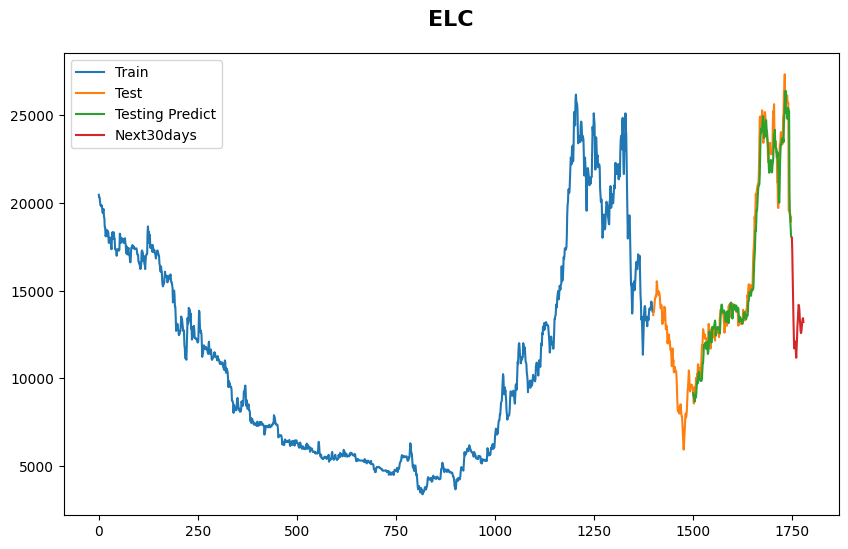

In [ ]:
import numpy as np

forecasted_next_30_days_reshaped = np.array(forecasted_next_30_days).reshape(-1, 1)


plt.figure(figsize=(10, 6))

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(train_data_index, scaler.inverse_transform(np.array(train_data).reshape(-1, 1)))

test_data_index = pd.RangeIndex(start=train_size, stop=train_size + test_size, step=1)
plt.plot(test_data_index, scaler.inverse_transform(np.array(test_data).reshape(-1, 1)))

test_data_index = pd.RangeIndex(start=train_size + 101, stop=train_size + test_size, step=1)
plt.plot(test_data_index, scaler.inverse_transform(y_pred_bnn_test.detach().numpy()))
# Lấy index từ ngày tiếp theo trở đi
index_forecasted = range(len(df1), len(df1)+ len(forecasted_next_30_days))
plt.plot(index_forecasted, scaler.inverse_transform(forecasted_next_30_days_reshaped))
plt.title('ELC', fontweight='bold', fontsize=16, pad=20)
plt.legend(['Train', 'Test', 'Testing Predict', 'Next30days'])
plt.show()


## Split data 9:1


In [ ]:
train_size, test_size, train_data, test_data = split_data(0.9, 0.1)

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.distributions import Normal

# Set random seed for reproducibility
torch.manual_seed(42)

# Define the hyperparameters
input_dim = X_train.shape[1]  # Dimension of input features
output_dim = 1  # Dimension of output (predicted value)
hidden_units = 64  # Number of hidden units
learning_rate = 0.001
num_epochs = 500
prior_sigma = 0.1  # Standard deviation of the prior

# Apply Min-Max scaling to the time series data

# Convert the scaled data to tensors
targets = torch.tensor(y_train).view(-1, 1).to(torch.float32)
time_series = torch.tensor(X_train).to(torch.float32)

# Create a DataLoader for batching and shuffling the data
dataset = TensorDataset(time_series, targets)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Define the BNN model
class BNNModel(nn.Module):
    def __init__(self, input_dim, hidden_units, output_dim, prior_sigma):
        super(BNNModel, self).__init__()
        self.layer1 = nn.Linear(input_dim, hidden_units)
        self.relu = nn.ReLU()
        self.layer2 = nn.Linear(hidden_units, output_dim)
        self.prior_sigma = prior_sigma

    def forward(self, x):
        x = self.layer1(x)
        x = self.relu(x)
        x = self.layer2(x)
        return x

    def kl_divergence(self):
        kl = 0
        for layer in [self.layer1, self.layer2]:
            weights = layer.weight
            kl += 0.5 * (torch.log(self.prior_sigma**2 / weights.var()) + (weights.var() + (weights.mean() - 0)**2) / self.prior_sigma**2 - 1)
        return kl

# Initialize the BNN model
model = BNNModel(input_dim, hidden_units, output_dim, prior_sigma)

# Define the loss function with KL divergence and negative log likelihood
def bnn_loss(outputs, targets):
    kl_divergence = model.kl_divergence()
    log_likelihood = -Normal(outputs, 1).log_prob(targets).mean()  # Assuming outputs is a Normal distribution
    return kl_divergence + log_likelihood

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
lowest_loss = float('inf')  # Initialize with positive infinity

# Training loop
for epoch in range(num_epochs):
    for batch_inputs, batch_targets in dataloader:
        # Forward pass
        predictions = model(batch_inputs)

        # Compute the combined loss (KL + negative log likelihood)
        loss = bnn_loss(predictions, batch_targets)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Update lowest_loss if current loss is lower
        if loss < lowest_loss:
            lowest_loss = loss
            torch.save(model.state_dict(), '/content/best-model-parameters.pt')

    # Print the combined loss (KL + negative log likelihood) after each epoch
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}")


Epoch 1/500, Loss: 0.9367431998252869
Epoch 2/500, Loss: 0.9198871850967407
Epoch 3/500, Loss: 0.9193533658981323
Epoch 4/500, Loss: 0.9191112518310547
Epoch 5/500, Loss: 0.9190376400947571
Epoch 6/500, Loss: 0.9189440011978149
Epoch 7/500, Loss: 0.9190869927406311
Epoch 8/500, Loss: 0.9190317988395691
Epoch 9/500, Loss: 0.9189772605895996
Epoch 10/500, Loss: 0.9190062880516052
Epoch 11/500, Loss: 0.9191671013832092
Epoch 12/500, Loss: 0.918939471244812
Epoch 13/500, Loss: 0.9189401865005493
Epoch 14/500, Loss: 0.9189643263816833
Epoch 15/500, Loss: 0.9190365076065063
Epoch 16/500, Loss: 0.9189815521240234
Epoch 17/500, Loss: 0.9190461039543152
Epoch 18/500, Loss: 0.919003963470459
Epoch 19/500, Loss: 0.918938934803009
Epoch 20/500, Loss: 0.9191159009933472
Epoch 21/500, Loss: 0.9190077185630798
Epoch 22/500, Loss: 0.9189628958702087
Epoch 23/500, Loss: 0.9189612865447998
Epoch 24/500, Loss: 0.9189502596855164
Epoch 25/500, Loss: 0.9189983010292053
Epoch 26/500, Loss: 0.919081807136535

In [ ]:
print(model)

BNNModel(
  (layer1): Linear(in_features=100, out_features=64, bias=True)
  (relu): ReLU()
  (layer2): Linear(in_features=64, out_features=1, bias=True)
)


In [ ]:
# Initialize the BNN model
best_model = BNNModel(input_dim, hidden_units, output_dim, prior_sigma)

# Load the state dictionary
state_dict = torch.load('/content/best-model-parameters.pt')

# Load the state dictionary into the model
best_model.load_state_dict(state_dict)

# Test the model
test = torch.tensor(X_test).to(torch.float32)
y_pred_bnn_test = best_model(test)


In [ ]:
# Forecast the next 30 days
forecasted_next_30_days = []

# Assuming df1 is your dataframe
last_10_days = df1.iloc[-time_step:].values.astype(np.float32)  # Apply normalization if needed

for i in range(30):
    X_forecast_tensor = torch.tensor(last_10_days[-time_step:]).unsqueeze(0).to(torch.float32)
    y_pred = best_model(X_forecast_tensor)
    forecasted_next_30_days.append(y_pred.item())

    # Update last_10_days with the latest prediction
    last_10_days = np.append(last_10_days, y_pred.detach().numpy())
    last_10_days = last_10_days[-time_step:]

# Print or use forecasted_next_30_days as needed
print(forecasted_next_30_days)


[0.680552065372467, 0.7028356790542603, 0.6871860027313232, 0.6934957504272461, 0.6980684995651245, 0.7104650139808655, 0.7149233818054199, 0.7553012371063232, 0.7829540371894836, 0.807903528213501, 0.8222625255584717, 0.826443076133728, 0.8625253438949585, 0.8841840028762817, 0.9152788519859314, 0.9194267988204956, 0.9474239349365234, 0.9648829698562622, 0.9800565242767334, 0.9771925210952759, 0.9835751056671143, 0.9871836304664612, 0.9922181963920593, 1.0086196660995483, 1.0171372890472412, 1.0283509492874146, 1.043798565864563, 1.0621803998947144, 1.0813500881195068, 1.089347243309021]


In [ ]:
forecasted_next_30_days

[0.680552065372467,
 0.7028356790542603,
 0.6871860027313232,
 0.6934957504272461,
 0.6980684995651245,
 0.7104650139808655,
 0.7149233818054199,
 0.7553012371063232,
 0.7829540371894836,
 0.807903528213501,
 0.8222625255584717,
 0.826443076133728,
 0.8625253438949585,
 0.8841840028762817,
 0.9152788519859314,
 0.9194267988204956,
 0.9474239349365234,
 0.9648829698562622,
 0.9800565242767334,
 0.9771925210952759,
 0.9835751056671143,
 0.9871836304664612,
 0.9922181963920593,
 1.0086196660995483,
 1.0171372890472412,
 1.0283509492874146,
 1.043798565864563,
 1.0621803998947144,
 1.0813500881195068,
 1.089347243309021]

In [ ]:
evaluation(scaler.inverse_transform(y_pred_bnn_test.detach().numpy()), scaler.inverse_transform(y_test.reshape(-1,1)))

RMSE = 1188.1276111324903
MAE = 765.0907266695202
MAPE = 3.2180048530477277


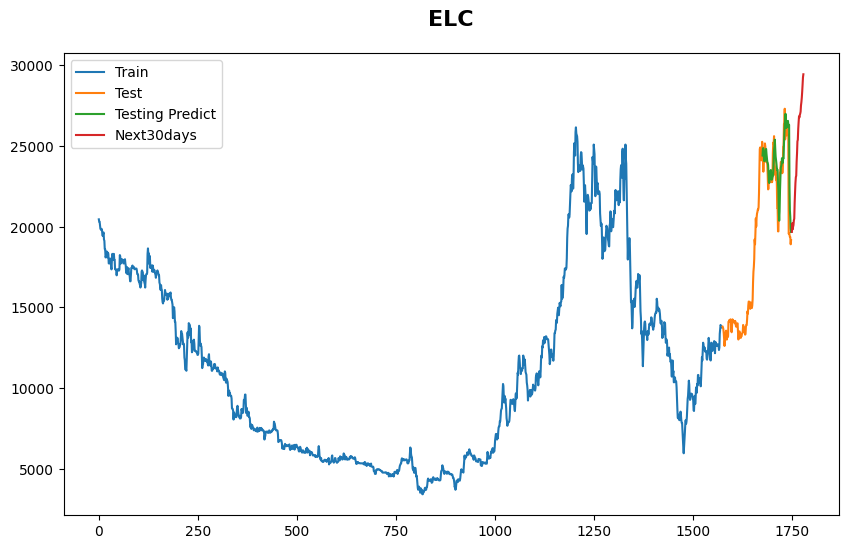

In [ ]:
import numpy as np

forecasted_next_30_days_reshaped = np.array(forecasted_next_30_days).reshape(-1, 1)


plt.figure(figsize=(10, 6))

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(train_data_index, scaler.inverse_transform(np.array(train_data).reshape(-1, 1)))

test_data_index = pd.RangeIndex(start=train_size, stop=train_size + test_size, step=1)
plt.plot(test_data_index, scaler.inverse_transform(np.array(test_data).reshape(-1, 1)))

test_data_index = pd.RangeIndex(start=train_size + 101, stop=train_size + test_size, step=1)
plt.plot(test_data_index, scaler.inverse_transform(y_pred_bnn_test.detach().numpy()))
# Lấy index từ ngày tiếp theo trở đi
index_forecasted = range(len(df1), len(df1)+ len(forecasted_next_30_days))
plt.plot(index_forecasted, scaler.inverse_transform(forecasted_next_30_days_reshaped))
plt.title('ELC', fontweight='bold', fontsize=16, pad=20)
plt.legend(['Train', 'Test', 'Testing Predict', 'Next30days'])
plt.show()
